In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from scipy import stats
import scipy as sc
import seaborn as sns

In [33]:
'''
se define el indice Datetime para eliminar las columnas referentes a las fechas
de las erupciones y su hora de inicio. ademas se calculan las energias pasando 
los valores de la columna energy.KeV a dos valores float.
'''
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom
'''
Tomamos todas las banderas flags y las unimos en una sola columna llamada Flags
df=df.fillna(value="")
df["Flags"]=df["flag.1"]+" "+df["flag.2"]+" "+df["flag.3"]+" "+df["flag.4"]\
+" "+df["flag.5"] 
for i in range (1,6): del df["flag."+str(i)]
'''
'''
Hago un calculo de las freciencias de la energia Promedio, Aunque por ahora
no es muy pertinente para el analisis, tal vez si pueda hacerse algo después.
'''
plank=4.135667696*pow(10,-15)
vluz=3*pow(10,8)
Frec=[]
long=[]
for i in df['EnergiaProm']:
    Frec.append(i/plank)
    long.append(vluz/(i/plank))
df['Frec']=Frec
df['Long']=long

'''funcion filtro recibe un dataframe una columna del mismo (un string),
y una condición, retorna un dataframe filtrado por el condicional 
''' 
def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  

def filtrof(data, Lbanderas): # Filtro por bandera, se podría agregar que eliminara también el rango de energía 3-6 keV
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
#print(dffiltro.value_counts('flag.2'))

$$
\textbf{graficas y analisis de datos}
$$

flare                   0
peak                    0
end                     0
duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19907
flag.4              20202
flag.5              61180
EnergiaMin              0
EnergiaMax              0
EnergiaProm             0
Frec                    0
Long                    0
duration.ls             0
dtype: int64

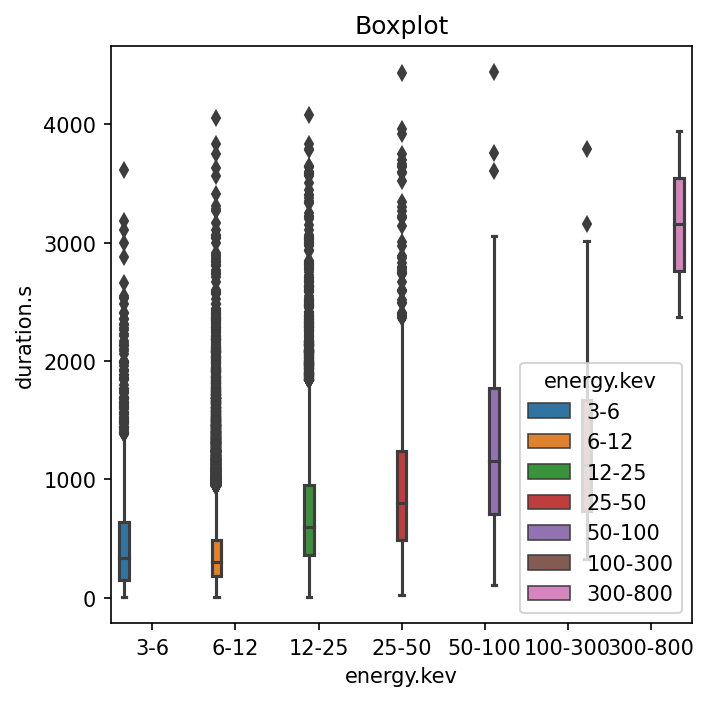

In [36]:

'''hipotesis estadistica de eventos solares filtrados por rangos de energia"""
se filtran los datos con respecto al rango de las energias presentes 
en esas erupciones
'''
df['duration.ls']=np.log(df['duration.s'])
lista=['NS','PE','P0']
dffiltro=filtrof(df,lista)
#df['energy.kev'].value_counts()
energy1 = Filtro(df,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(df,'energy.kev','12-25')
energy3 = Filtro(df,'energy.kev','25-50')
energy4 = Filtro(df,'energy.kev','50-100')
dfe=pd.concat([energy1,energy2,energy3]).sort_values('Datetime')
dfdt = dfe['duration.s']
dfep = dfe['EnergiaProm']
datos4 = energy4['duration.s']
'''diagrama de caja y bigote para la duracion 
de las eripciones con respecto a los rangos de energia'''
plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(data=dffiltro.sort_values('EnergiaProm'),x='energy.kev',y='duration.s',hue='energy.kev')
plt.title('Boxplot')
df.isnull().sum()

$$
 \textbf{grafica de la posición de las erupciones clasificada por sus energias}
$$

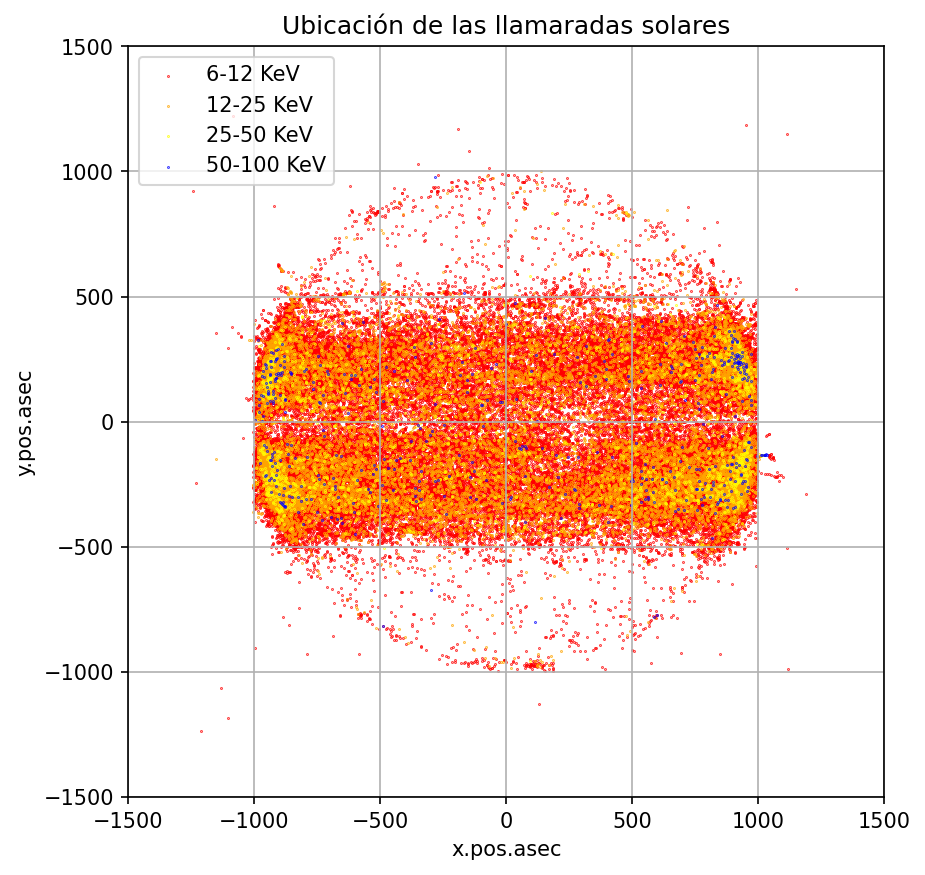

In [6]:
'''
scatter de las posiciones x.pos.asec y y.pos.asec
de cada rango de energias mayores al rango 3-6 kev
probablamente mejor con un cmap
'''
plt.figure(figsize=(6.5,6.5), dpi = 150, edgecolor='black')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.grid()
plt.title('Ubicación de las llamaradas solares')
plt.ylabel('y.pos.asec')
plt.xlabel('x.pos.asec')
plt.scatter(energy1['x.pos.asec'], energy1['y.pos.asec'],s=0.1, color='red', label='6-12 KeV')
plt.scatter(energy2['x.pos.asec'], energy2['y.pos.asec'],s=0.1, color='orange',label='12-25 KeV')
plt.scatter(energy3['x.pos.asec'], energy3['y.pos.asec'],s=0.1, color='yellow',label='25-50 KeV')
plt.scatter(energy4['x.pos.asec'], energy4['y.pos.asec'],s=0.1, color='blue', label='50-100 KeV')
plt.legend()

$$
\textbf{Matriz de correlación}
$$

<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

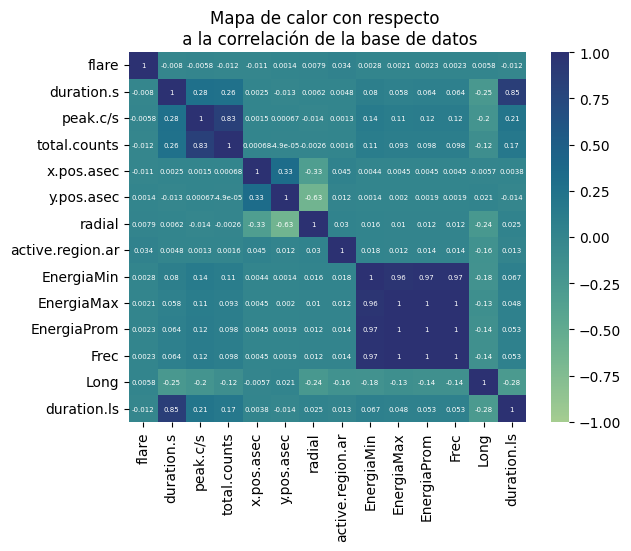

In [7]:
'''se trabaja un mapa de calor para la 
   matriz  de correlación'''

matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':5}
           ,vmin=-1,vmax=1)

<Figure size 640x480 with 0 Axes>

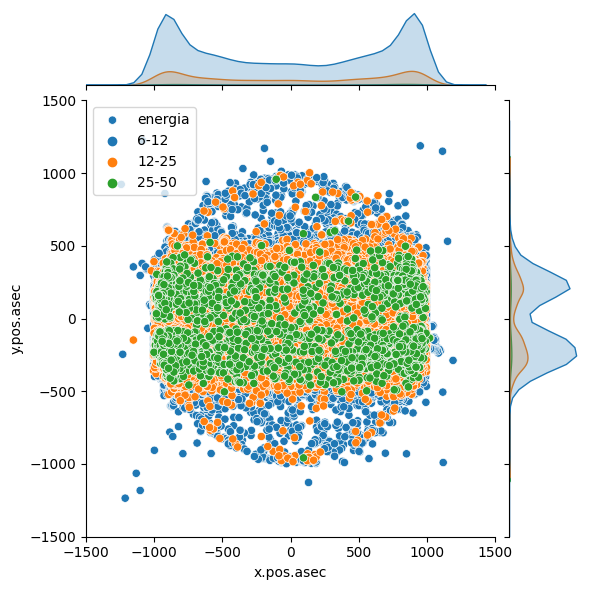

In [8]:
plt.figure()
sns.jointplot(dfe.sort_values('EnergiaProm'), x='x.pos.asec',y='y.pos.asec',kind='scatter',hue='energy.kev',xlim=(-1500,1500),ylim=(-1500,1500),label='energia')
plt.legend(loc='upper left')

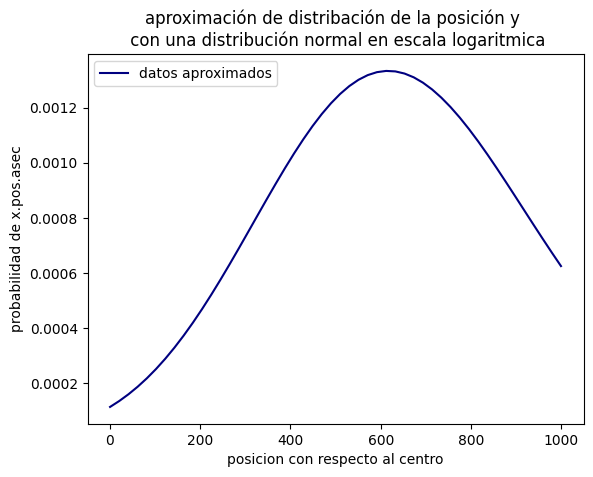

In [9]:
dfx=dfe[dfe['x.pos.asec'] > 0]
dfx=dfx[dfx['x.pos.asec'] < 1000]
dfy=dfe[dfe['y.pos.asec']> 0]
dfy=dfy[dfy['y.pos.asec']< 1000]
'''
aproximación de valores en y con una distribución normal en escala logaritmica
'''
dfx['log.x']=np.log(dfx['x.pos.asec'])
dfy['log.y']=np.log(dfy['y.pos.asec'])
#fil = dffy['energy.kev'] == '6-12' # Se filtra por rango de energias
#dataF = dffy[fil]
ky=1+np.log2(len(dfx['x.pos.asec']))
disty=stats.chi2
parametrosy= disty.fit(data=dfx['x.pos.asec'])
xapy=np.linspace(min(dfx['x.pos.asec']),max(dfx['x.pos.asec']))
yapy=disty.pdf(xapy,*parametrosy)
plt.figure()
#sns.kdeplot(data=dfx.sort_values('Datetime'),x='log.x',hue='energy.kev',label='logaritmo de posición y de los datos')
plt.title('aproximación de distribación de la posición y \n con una distribución normal en escala logaritmica')
plt.plot(xapy,yapy,label='datos aproximados',color='navy')
plt.xlabel('posicion con respecto al centro')
plt.ylabel('probabilidad de x.pos.asec')
plt.legend()
#plt.savefig('DistY')
#sns.histplot(data=dfy.sort_values('Datetime'))

In [10]:
#sns.kdeplot(data=dffe.sort_values('EnergiaProm'),x='x.pos.asec',y='y.pos.asec',hue='energy.kev',xlim=(-1000,1000),ylim=(-1000,1000))

<AxesSubplot:xlabel='x.pos.asec', ylabel='Density'>

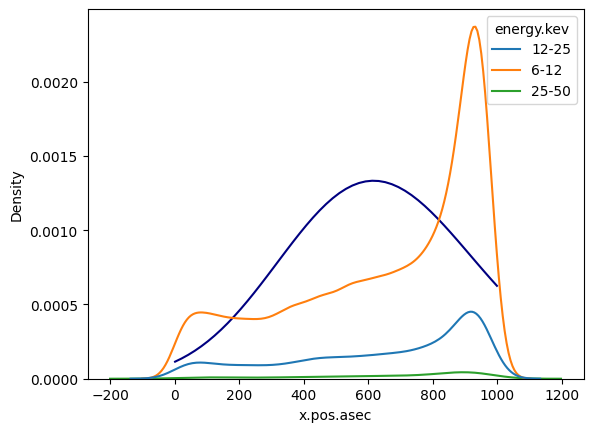

In [11]:
'''
aproximación de los valores en x
'''
dfx['log.x']=np.log(dfx['x.pos.asec'])
kx=1+np.log2(len(dfx['y.pos.asec']))
#sns.histplot(data=dffx.sort_values('Datetime'),x='x.pos.asec',hue='energy.kev',bins=int(kx))
plt.figure()
plt.plot(xapy,yapy,label='datos aproximados',color='navy')
sns.kdeplot(dfx.sort_values('Datetime'),x='x.pos.asec',hue='energy.kev')

$$
\textbf{Prueba de hipotesis t de student y f de fisher para las duraciones}
$$
se realizan dos funciones en las que se trabajan unas pruebas de hipotesis con respecto a las distribuciones t de student y F de Fisher para determinar si hay una diferencia significativa entre las medias poblacionales y aunque en un principio se intentó con una t student la verdad es que la evaluación de su estadistico proporcionaba valores (pvalores, e intervalos) que en primer lugar carecian de sentido pues aunque los datos mostrabán unas diferencias con respecto a los valores de duracion promedio dependiendo de la energía, y se observa una independencia del promedio de estos valores entre los rangos energeticos (osea la duracion media de las llamaradas de cada valor de energia es independiente del resto de valores en los que no se encuentra)
al plantear la hipotesis nula en la que las medias poblacionales para los valores de energia eran iguales para la F de fisher se observó que el nivel de significancia fue muy bajo ademas que el estadistico de esta hipotesis , queda fuerá del intervalo de confianza. Por lo que se tienen suficientes argumentos para rechazar la hipotesis nula, se seleccionó la distribución F de fisher ya que se cumplen que las variables a evaluar (las duraciones de los distintos rangos de energia son variables aleatorias que se aproximan a una distribución chi-cuadrada)

C:\Users\Juan Jimenez\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


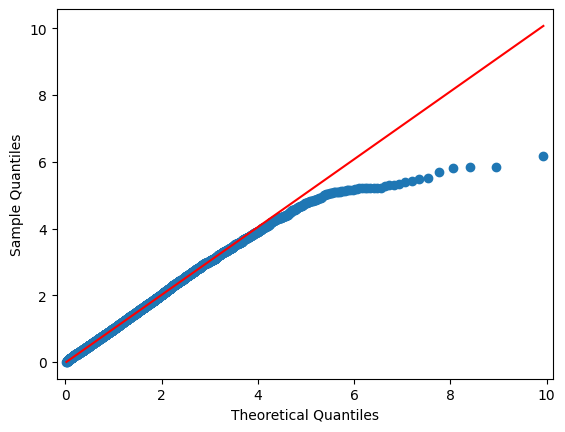

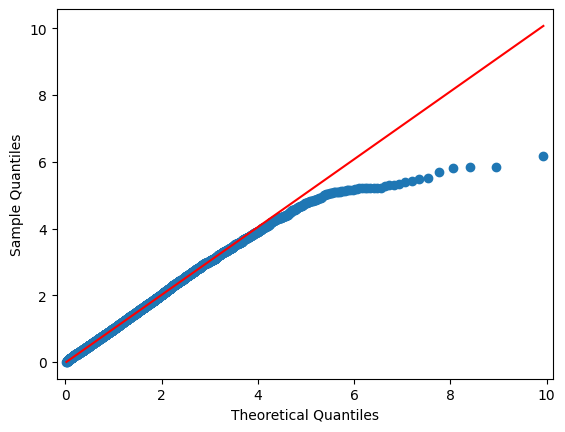

In [12]:
#sm.qqplot?
sm.qqplot(data=energy2['duration.s'], dist=stats.f , fit=True, line='q')

In [13]:
#Funcion para prueba estadistica t student
def PDMT(dfa,dfb,col,alpha,hip):
# se sacan los promedios, el numero de muestras y las desviaciones estandar con n-1 grados de libertad 'ddof'
    proa=dfa[col].mean()
    prob=dfb[col].mean()
    na=len(dfa[col])
    nb=len(dfb[col])
    sta=dfa[col].std(ddof=(na-1))
    stb=dfb[col].std(ddof=(nb-1))
# se hace la diferencia de las medias muestrales y se calculan los grados de libertad para una t student de 
# dos variables aleatorios con varianzas diferentes y desconocidas esta se lleva al entero menor (aproximación de scatterhwaite)
    Promdif=prob-proa
    v=pow((pow(sta,2)/na)+(pow(stb,2)/nb),2)/((pow(pow(sta,2)/na,2)/na-1)+(pow(pow(stb,2)/nb,2)/nb-1))
    kv=int(v)
# se definen el t estadistico de la prueba Test y el valor critico de una distibucion t de student
# con kv grados de libertad , con un indice de sigfinicancia del 0.05 
    Tdeno=np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb))
    Tnume=(Promdif-hip)
    Test=Tnume/Tdeno
    conf=(1.0-alpha)
    cv=stats.t.ppf(conf, kv)
#intervalos de confianza a partir del valor v y se determina el valor estadistico p para la hipotesis nula de que mu_a=mu_b
    coin=Tnume-(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    coif=Tnume+(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    #ps=1.0-sc.special.stdtr(kv,np.abs(T))
    p=(1.0-stats.t.cdf(np.abs(Test),kv))
    return Test, coin, coif, cv, Promdif,p

# Funcion prueba estadistica F de fisher
def PDVF(dfa,dfb,col,alpha):
# se definen las medias muestrales, el numero de muestras, los grados de libertad de cada muestra y las desviaciones estandar
# con los respectivos grados de libertad de las muestras
    pro1=dfa[col].mean()
    pro2=dfb[col].mean()
    n1=len(dfa[col])
    n2=len(dfb[col])
    dof1=(n1-1)
    dof2=(n2-1)
    st1=dfa[col].std(ddof=dof1)
    st2=dfb[col].std(ddof=dof2)
# grado de significancia alpha=0.025, intervalo de confianza, F valor critico, , F estadistico, y valor p 
    conf=1.0-alpha
    fsup=stats.f.ppf(alpha,dof2,dof1)
    finf=(1/fsup)
    Fest=pow(st1,2)/pow(st2,2)
    pf=1-stats.f.cdf(abs(Fest),dof1,dof2)
    return fsup, finf , Fest , pf

In [14]:
#pruebas estadisticas para la duracion entre dos poblaciones categorizadas por su energia usando F de fisher y T de student 
pruebaEnergiaDuracionT=PDMT(energy1,energy3,'duration.s',0.025,0)
fup, finf ,Fest, pf=PDVF(energy1,energy3,'duration.s',0.025)
PruebaEnergiaXposF=PDVF(energy1,energy2,'x.pos.asec',0.025)
PruebaEnergiaYposF=PDVF(energy1,energy2,'y.pos.asec',0.025)
#print(pruebaEnergiaDuracionT)
print(PruebaEnergiaXposF)
print("el intervalo de confianza es (",finf,",",fup,") con un F estadistico: ",Fest," y un valor estadistico",pf,)

(0.9782622650097613, 1.0222207640708925, 5.717387482597769, 1.1102230246251565e-16)
el intervalo de confianza es ( 1.0648328408642913 , 0.939114536689469 ) con un F estadistico:  9.857397112740983  y un valor estadistico 1.1102230246251565e-16


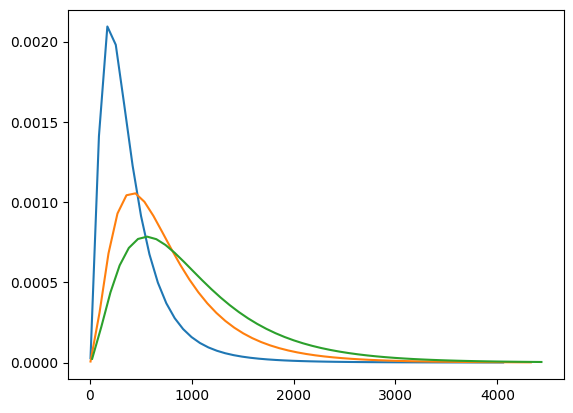

In [55]:
def AproxGra(dfa,col):
    dist=stats.f
    freedom=len(dfa[col])-1
    paradist= dist.fit(data=dfa[col])
    xd=np.linspace(min(dfa[col]),max(dfa[col]))
    yd=dist.pdf(xd,*paradist)
    return xd, yd, paradist
x1,y1,p1 = AproxGra(energy1,'duration.s')
x2,y2,p2 = AproxGra(energy2,'duration.s')
x3,y3,p3 = AproxGra(energy3,'duration.s')
plt.figure()
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
#print(p1)

<AxesSubplot:xlabel='duration.s', ylabel='Count'>

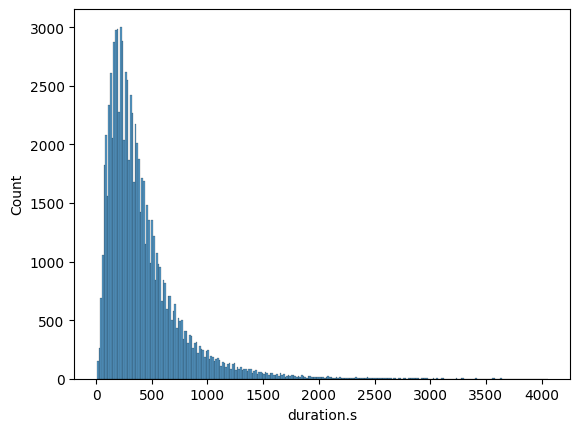

In [56]:
#sns.histplot(data=energy1,x='duration.s')

In [17]:
#stats.ttest_1samp(a=energy2['duration.s'],popmean=dfe['duration.s'].mean())

In [ ]:
plt.scatter()